# WALMART SALES FORECASTING - TIME SERIES ANALYSIS

**AIM:** One of the most crucial elements of strategic planning is predicting future sales for a company. We aim to analyze in depth how internal and external factors of one of the biggest companies in the US can affect their Weekly Sales in the future. Overall, the goal is to provide insights that can inform strategic planning and decision-making for the company.

45 Walmart shops nationwide were included in this investigation, which used data acquired between 2010 and 2012.We also have access to external data, such as the CPI, unemployment rate, and fuel prices in the vicinity of each store, which should ideally aid in the creation of a more thorough analysis.

DATASET: Walmart Recruiting - Store Sales Forecasting (https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data)

In [ ]:
# Importing all necessary libraries to proceed with this project.

import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
import random
import sqlite3
from itertools import cycle, islice

# Import timedelta from datetime library
from datetime import timedelta

import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")


ss = StandardScaler()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.


###Dataset Importing - 3 datasets

In [ ]:
walmart = pd.read_csv('train.csv')

walmart_feature = pd.read_csv('features.csv')

walmart_store = pd.read_csv('stores.csv')

#1. Data Pre-processing

In [ ]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
walmart.shape

(421570, 5)

 ### Data Cleaning - Merging all 3 datasets

In [ ]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)

In [ ]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, walmart_feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

In [ ]:
print(data.shape)

(6435, 15)


In [ ]:
data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,1641957.44,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,1611968.17,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,1409727.59,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,1554806.68,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
#let's encode the categorical column : IsHoliday

data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x == True else 0)
# Will convert the bool to 1 and 0 for easier use later.
#data.IsHoliday=data.IsHoliday.map(lambda x: 1 if x==True else 0)

In [ ]:
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
dtype: object

In [ ]:
# yes my assumption was correct python have something to do with date format. 
# Now converting "Date"  to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [ ]:
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Size,6435.0,1.302876e+05,63117.022465,34875.000,70713.000,126512.000000,2.023070e+05,2.196220e+05
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
MarkDown1,2280.0,6.855587e+03,8183.310015,0.270,1679.190,4972.590000,8.873583e+03,8.864676e+04
MarkDown2,1637.0,3.218966e+03,9268.082387,-265.760,37.200,187.040000,1.785290e+03,1.045195e+05
MarkDown3,2046.0,1.349853e+03,9287.242800,-29.100,4.700,22.700000,9.998750e+01,1.416306e+05
MarkDown4,1965.0,3.303858e+03,6211.203947,0.220,483.270,1419.420000,3.496080e+03,6.747485e+04
MarkDown5,2295.0,4.435262e+03,5868.933325,135.160,1702.565,3186.520000,5.422080e+03,1.085193e+05


In [ ]:
#add a 'week' column to the dataset for further analysis
data['Week'] = data.Date.dt.isocalendar().week 

In [ ]:
data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Store,6435.000000,23.000000,12.988182,1.000000,12.000000,23.000000,34.000000,45.000000
Weekly_Sales,6435.000000,1046964.877562,564366.622054,209986.250000,553350.105000,960746.040000,1420158.660000,3818686.450000
Size,6435.000000,130287.600000,63117.022465,34875.000000,70713.000000,126512.000000,202307.000000,219622.000000
Temperature,6435.000000,60.663782,18.444933,-2.060000,47.460000,62.670000,74.940000,100.140000
Fuel_Price,6435.000000,3.358607,0.459020,2.472000,2.933000,3.445000,3.735000,4.468000
MarkDown1,2280.000000,6855.587430,8183.310015,0.270000,1679.190000,4972.590000,8873.582500,88646.760000
MarkDown2,1637.000000,3218.965504,9268.082387,-265.760000,37.200000,187.040000,1785.290000,104519.540000
MarkDown3,2046.000000,1349.853021,9287.242800,-29.100000,4.700000,22.700000,99.987500,141630.610000
MarkDown4,1965.000000,3303.858142,6211.203947,0.220000,483.270000,1419.420000,3496.080000,67474.850000
MarkDown5,2295.000000,4435.262240,5868.933325,135.160000,1702.565000,3186.520000,5422.080000,108519.280000


#2. EDA - Visualisation (using plotly)

In [ ]:
df_weeks = data.groupby('Week').sum()

import plotly.express as px
fig = px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, title = 'Sales over weeks')
fig.update_traces(line_color='deeppink', line_width=3)

In [ ]:
df_weeks.head()

,Store,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Year
Week,,,,,,,,,,,,,,,
1,2070,8.773121e+07,11725884,3438.27,287.489,214551.50,956964.10,5105.11,44069.57,223036.75,15421.135275,710.979,0,585,181035
2,2070,8.269676e+07,11725884,3167.09,291.404,148560.51,420168.49,3172.06,22332.89,165721.27,15430.151991,710.979,0,1215,181035
3,2070,8.273564e+07,11725884,3476.88,293.341,104001.81,141268.63,3098.39,27717.05,122143.56,15443.190027,710.979,0,1845,181035
4,2070,7.943483e+07,11725884,3455.57,294.581,63331.86,74200.84,3089.75,4254.13,116290.60,15456.228061,710.979,0,2475,181035
5,3105,1.419895e+08,17588826,4919.52,418.696,1624211.71,126542.47,6408.63,1286593.08,267767.25,23017.155918,1098.848,0,540,271485


In [ ]:
import plotly.graph_objs as go
from plotly import tools

fig = go.Figure()

#fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )

fig.update_layout(title = 'Sales vs Markdown', xaxis_title = 'Weeks')

####Filling Missing Values

In [ ]:
## setting all missing values in markdown columns to -500 for now. We will treat them later while performing Feature scaling
data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

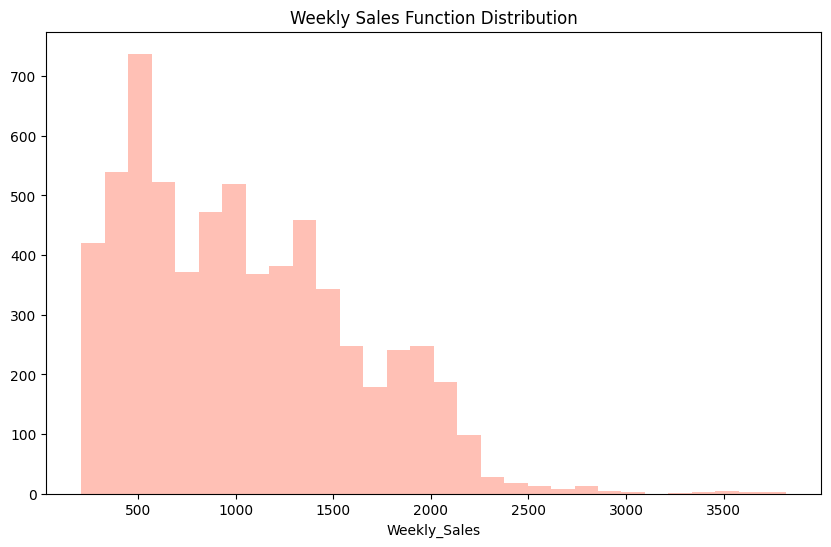

In [ ]:
# From the Describe function we see that weekly sales for each store are very high. 
# we will scale down the value for ease of use and revert back when we look residuals or where necessary

plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000

sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()

###Weekly Sales - Scatter Plot

In [ ]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

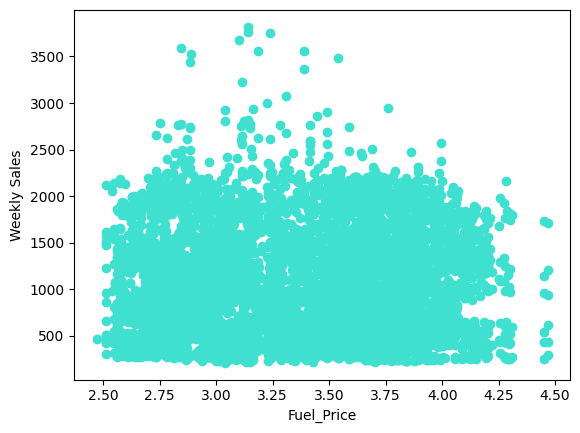

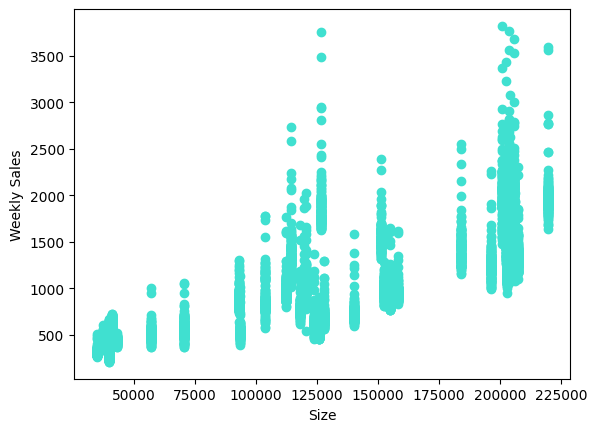

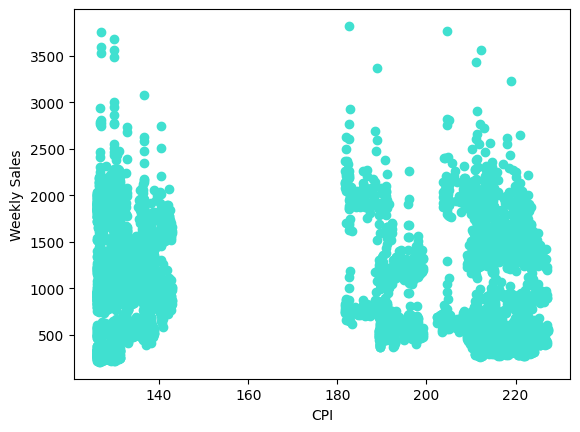

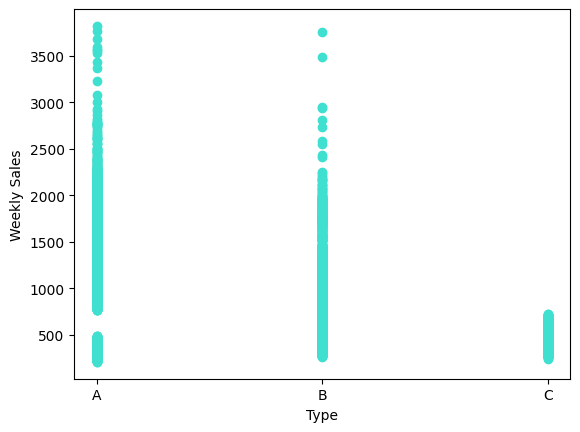

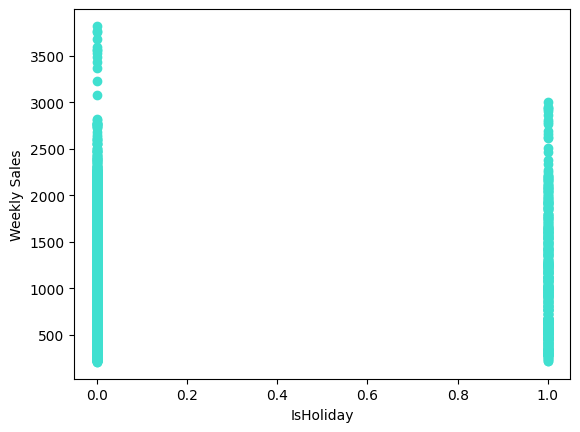

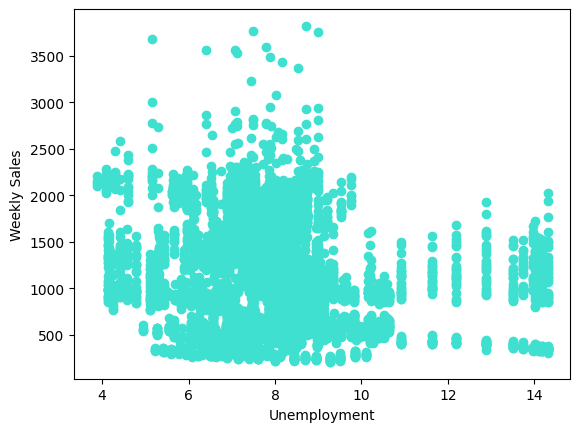

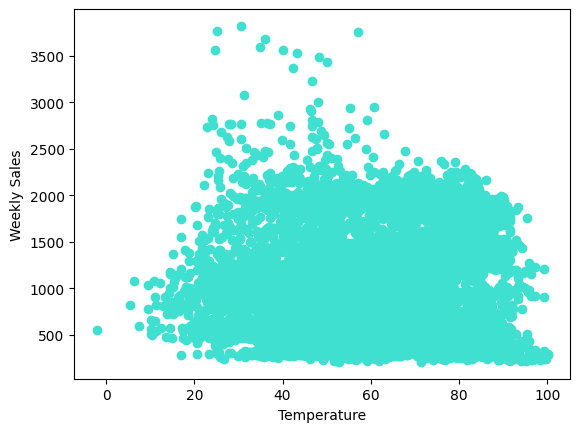

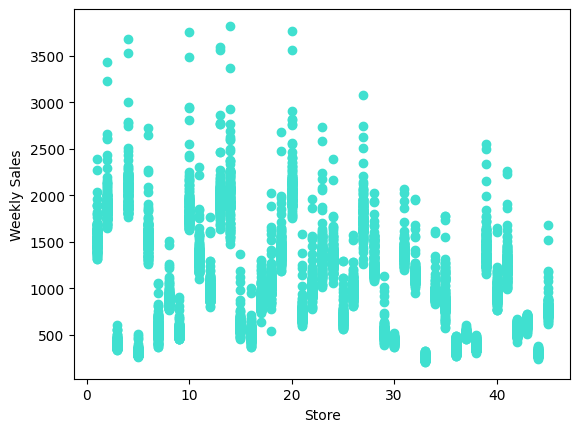

In [ ]:
scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')

In [ ]:
data['Week'] = data.Date.dt.isocalendar().week 
data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Month,Year,Week
0,1,2010-02-05,1643.69090,A,151315,42.31,2.572,-500.0,-500.0,-500.0,-500.0,-500.0,211.096358,8.106,0,5,Feb,2010,5
1,1,2010-02-12,1641.95744,A,151315,38.51,2.548,-500.0,-500.0,-500.0,-500.0,-500.0,211.242170,8.106,1,12,Feb,2010,6
2,1,2010-02-19,1611.96817,A,151315,39.93,2.514,-500.0,-500.0,-500.0,-500.0,-500.0,211.289143,8.106,0,19,Feb,2010,7
3,1,2010-02-26,1409.72759,A,151315,46.63,2.561,-500.0,-500.0,-500.0,-500.0,-500.0,211.319643,8.106,0,26,Feb,2010,8
4,1,2010-03-05,1554.80668,A,151315,46.50,2.625,-500.0,-500.0,-500.0,-500.0,-500.0,211.350143,8.106,0,5,Mar,2010,9


### Average Weekly Sales

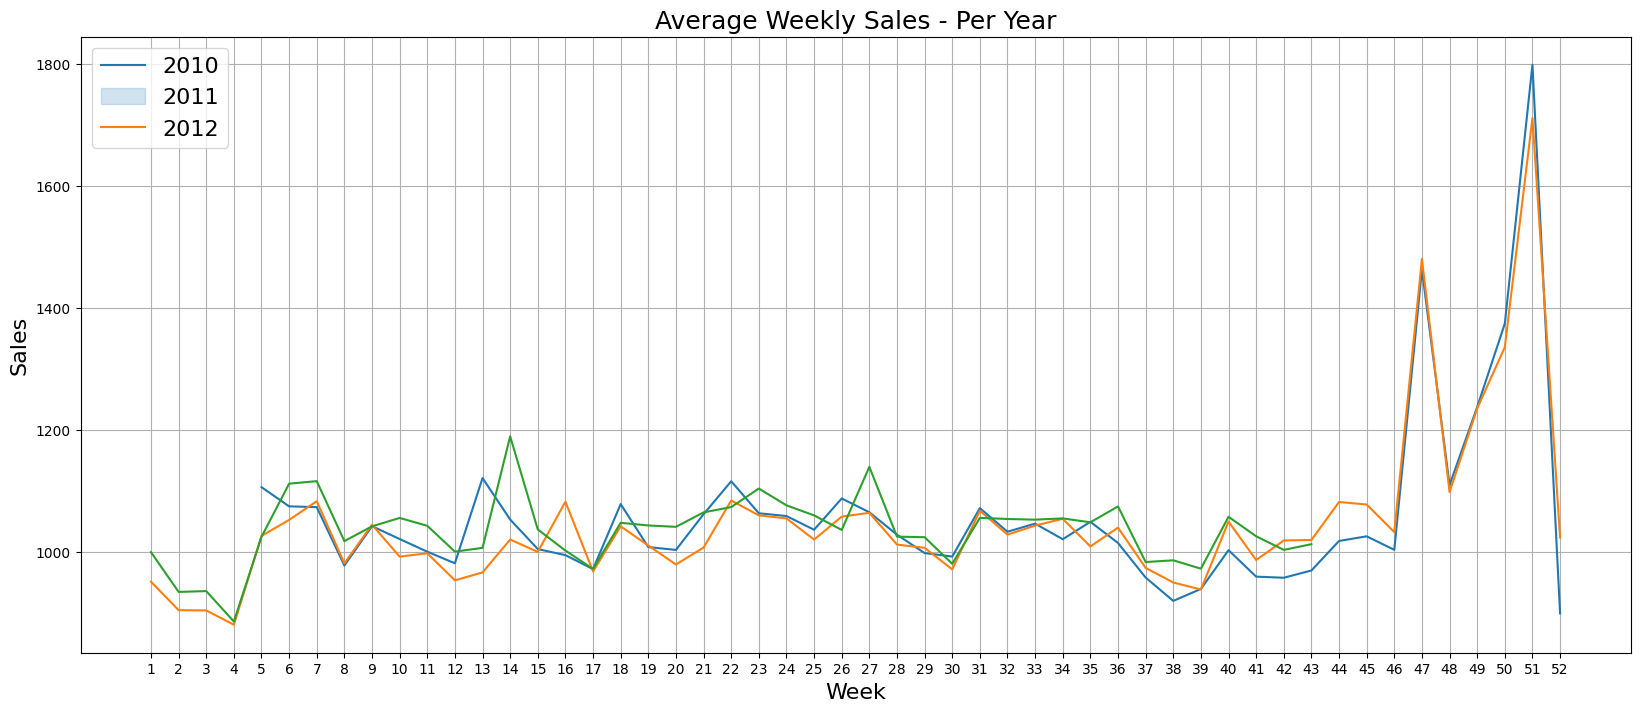

In [ ]:
weekly_sales_2010 = data[data.Year==2010]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2011 = data[data.Year==2011]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2012 = data[data.Year==2012]['Weekly_Sales'].groupby(data['Week']).mean()

# Convert the index values to numeric
weekly_sales_2010.index = weekly_sales_2010.index.astype(int)
weekly_sales_2011.index = weekly_sales_2011.index.astype(int)
weekly_sales_2012.index = weekly_sales_2012.index.astype(int)

plt.figure(figsize=(20, 8))
sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


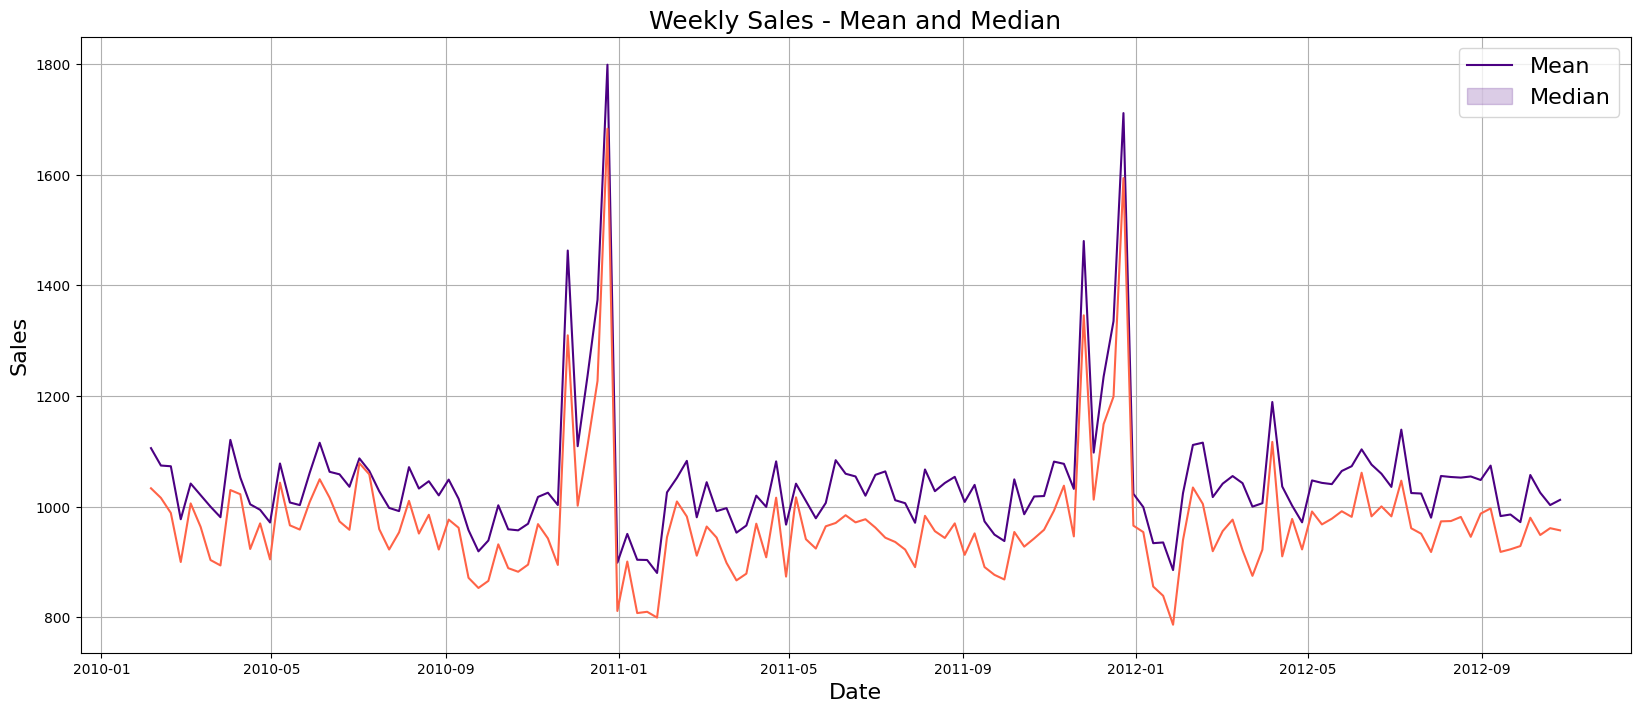

In [ ]:
weekly_sales_mean = data['Weekly_Sales'].groupby(data['Date']).mean()
weekly_sales_median = data['Weekly_Sales'].groupby(data['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_mean.index, y=weekly_sales_mean.values, color = 'indigo')
sns.lineplot(x=weekly_sales_median.index, y=weekly_sales_median.values, color = 'tomato')
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

### Weekly Sales vs Size of Store - Line Plot

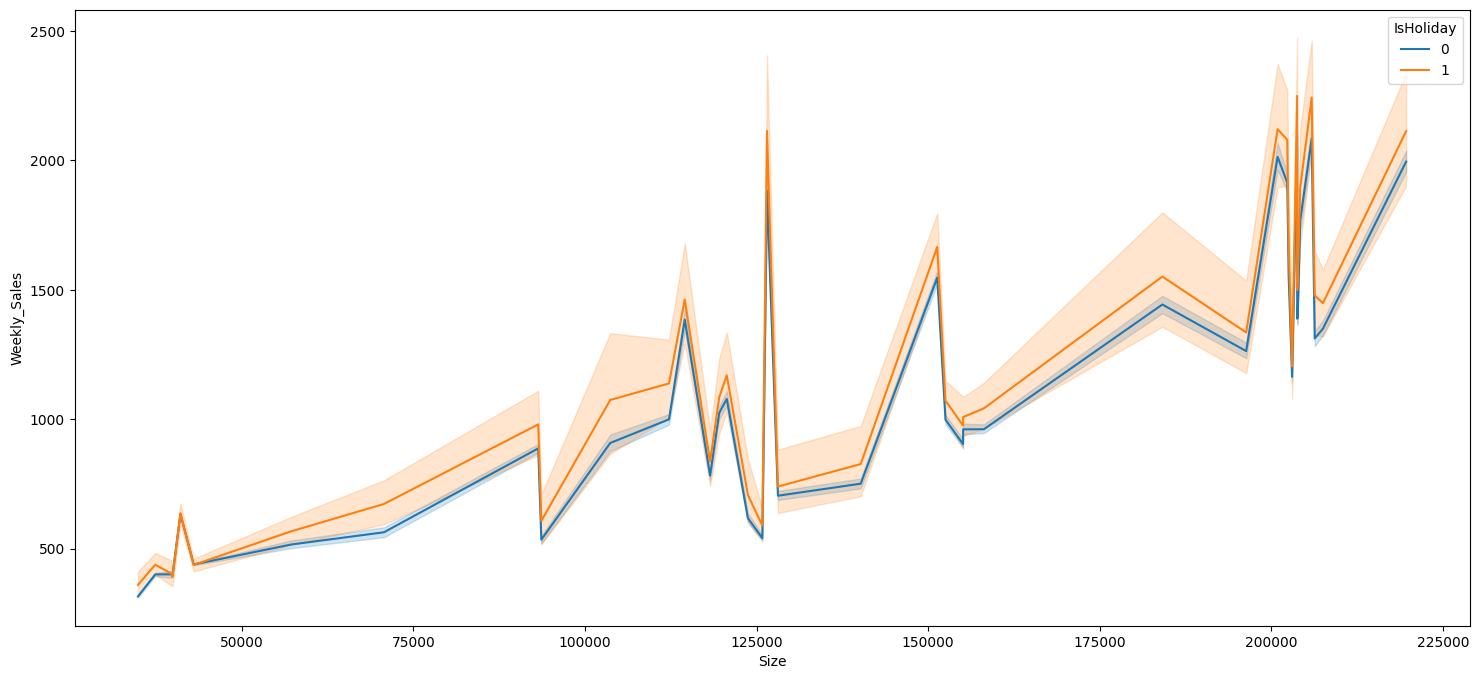

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot ( data = data, x = 'Size', y =  'Weekly_Sales', hue = 'IsHoliday');

### Weekly Sales vs Temperature - Histogram

In [ ]:
px.histogram(data, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box')

### Weekly Sales vs Fuel Price - Histogram

In [ ]:
px.histogram(data, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box')

### Weekly Sales vs CPI (Consumer Price Index) - Histogram

In [ ]:
px.histogram(data, x='CPI', y ='Weekly_Sales', color='IsHoliday')

### Average Sales per Store

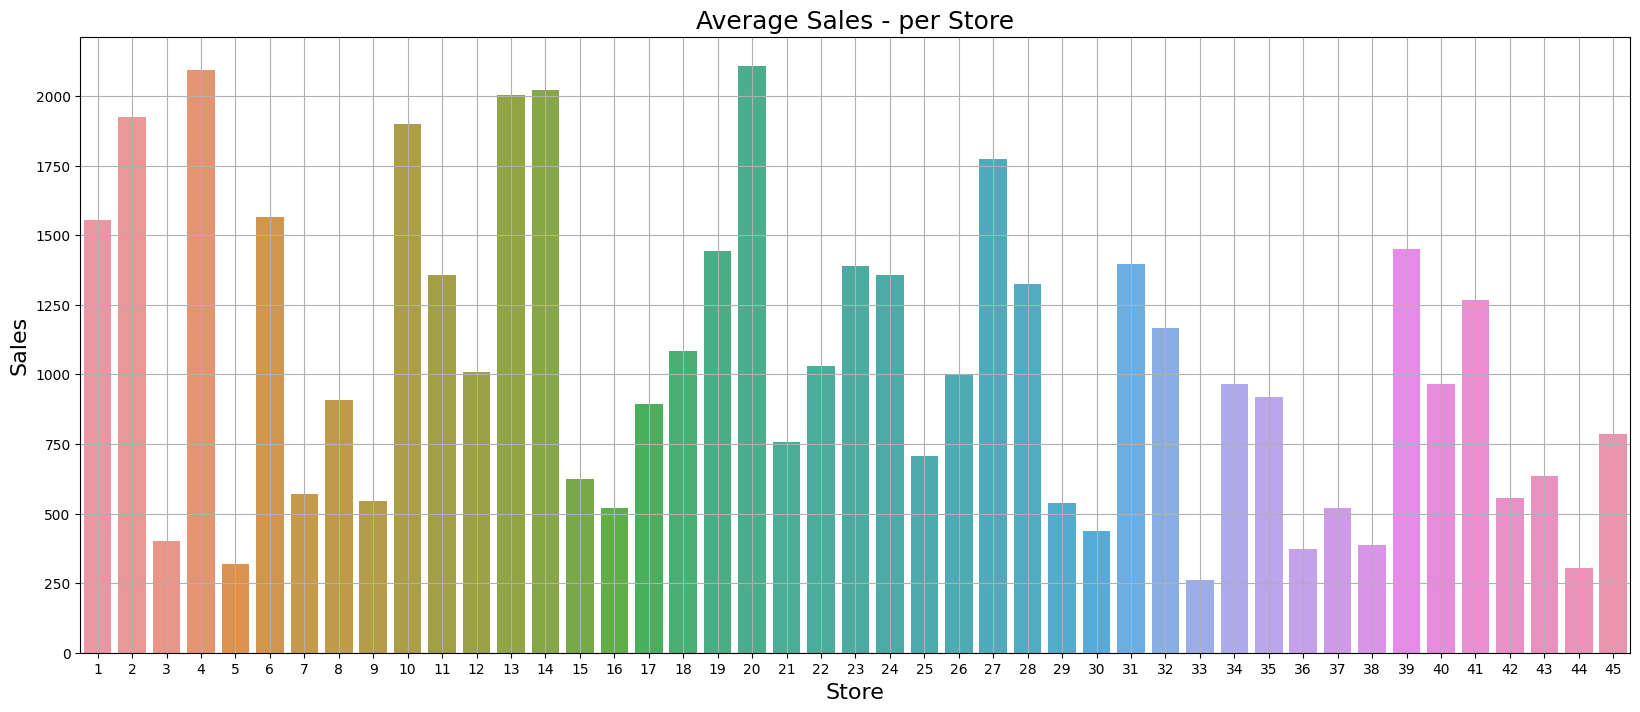

In [ ]:
weekly_sales = data['Weekly_Sales'].groupby(data['Store']).mean()
plt.figure(figsize=(20, 8))
plt.style.use('default')
sns.barplot(x=weekly_sales.index, y=weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()


### Correlation Matrix

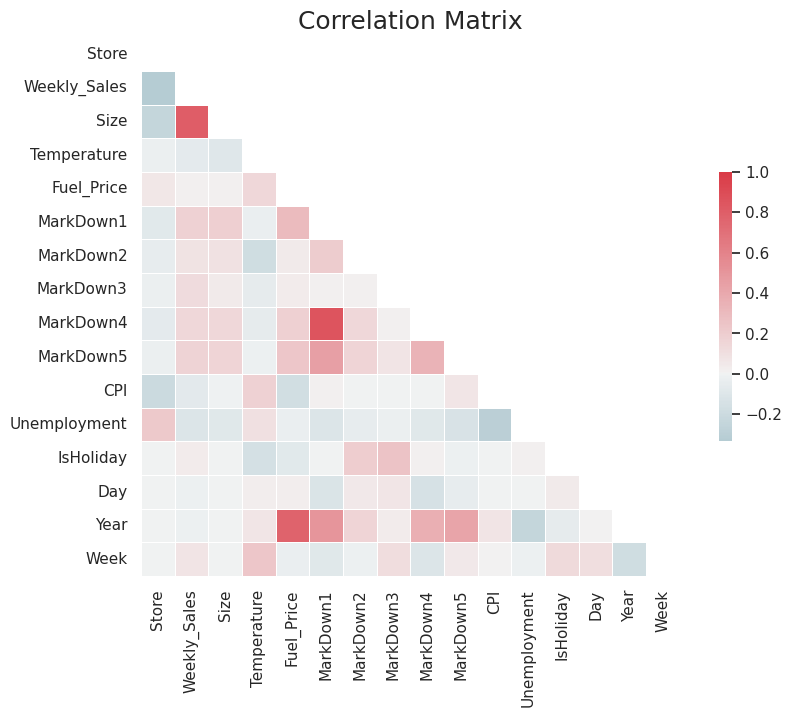

In [ ]:
sns.set(style="white")

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set the desired figure size
fig, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


#3. Stationarity Checks

####Time series data is said to be stationary when statistical properties like mean, standard deviation are constant and there is no seasonality.

Null Hypothesis (H0): There is no significant relationship between the independent variables (such as store size, location, etc.) and the sales of Walmart stores. In other words, the independent variables do not have any impact on the sales.

Alternative Hypothesis (HA): There is a significant relationship between the independent variables and the sales of Walmart stores. The independent variables have an impact on the sales.

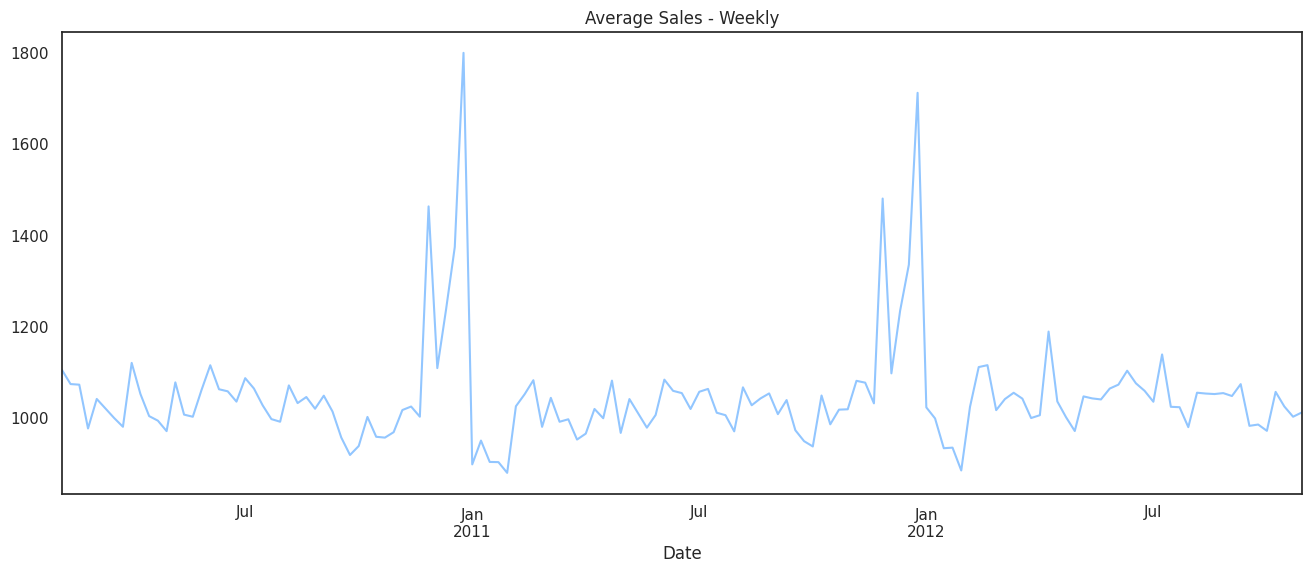

In [117]:
df_week = data.resample('W').mean() #resample data as weekly
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

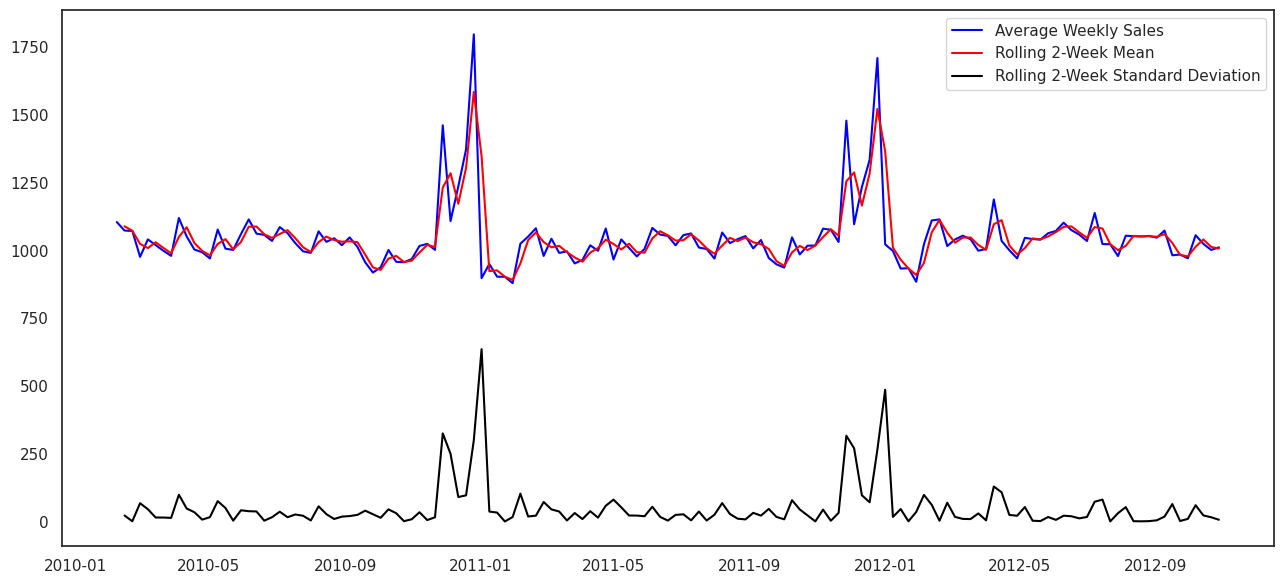

In [118]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [119]:
from statsmodels.tsa.stattools import adfuller

# Extract the 'Weekly_Sales' column from the DataFrame
weekly_sales = data['Weekly_Sales']

# Perform the ADF test
result =adfuller(df_week['Weekly_Sales'])

# Extract the p-value from the ADF test result
p_value = result[1]

# Print the p-value
print("ADF Test p-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("The data is stationary (reject the null hypothesis)")
else:
    print("The data is non-stationary (fail to reject the null hypothesis)")


ADF Test p-value: 2.675979158986003e-07
The data is stationary (reject the null hypothesis)


The p-value associated with the ADF statistic is 2.675. This p-value is very small (close to zero), which suggests strong evidence against the null hypothesis. Typically, if the p-value is below a significance level (such as 0.05), we reject the null hypothesis of non-stationarity. In this case, since the p-value is extremely small, we can confidently reject the null hypothesis and conclude that the **data is stationary**.

In [116]:
adfuller(df_week['Weekly_Sales'])

(-5.908297957186336,
 2.675979158986003e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 1571.5692010915309)

The ADF statistic value is **-5.90**. This is a negative value, and more negative values indicate a stronger **rejection of the null hypothesis** (non-stationarity). In this case, the ADF statistic is sufficiently negative.

Hence independent variables such as store size, location, weekly sales etc. have an impact on the sales.

#4. Identify Patterns

###Time Series Modelling

#####Example: Time Series Analysis on Store - 4

In [120]:
data1 = pd.read_csv('train.csv')
data1.set_index('Date', inplace=True)

store4 = data1[data1.Store == 4]
# there are about 45 different stores in this dataset.

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)

#####Example: Time Series Analysis on Store - 6

In [ ]:
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]
# there are about 45 different stores in this dataset.

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)

### Weekly Sales of Store4 vs Store6

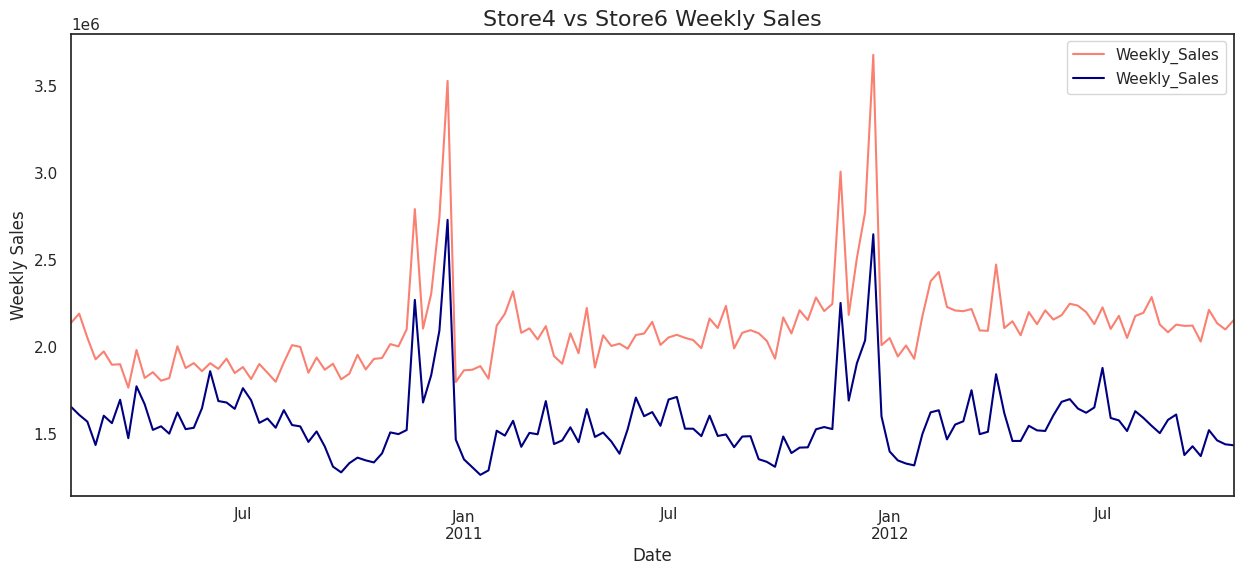

In [126]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales
y1.plot(figsize=(15, 6), legend=True, color = 'salmon')
y2.plot(figsize=(15, 6), legend=True, color = 'navy')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

This shows an interesting trend during year ends (during both 2011 & 2012). The best thing is both the stores have almost the same trends and spike just the magnitude is different.


###Identifying Patterns in data

<Figure size 640x480 with 0 Axes>

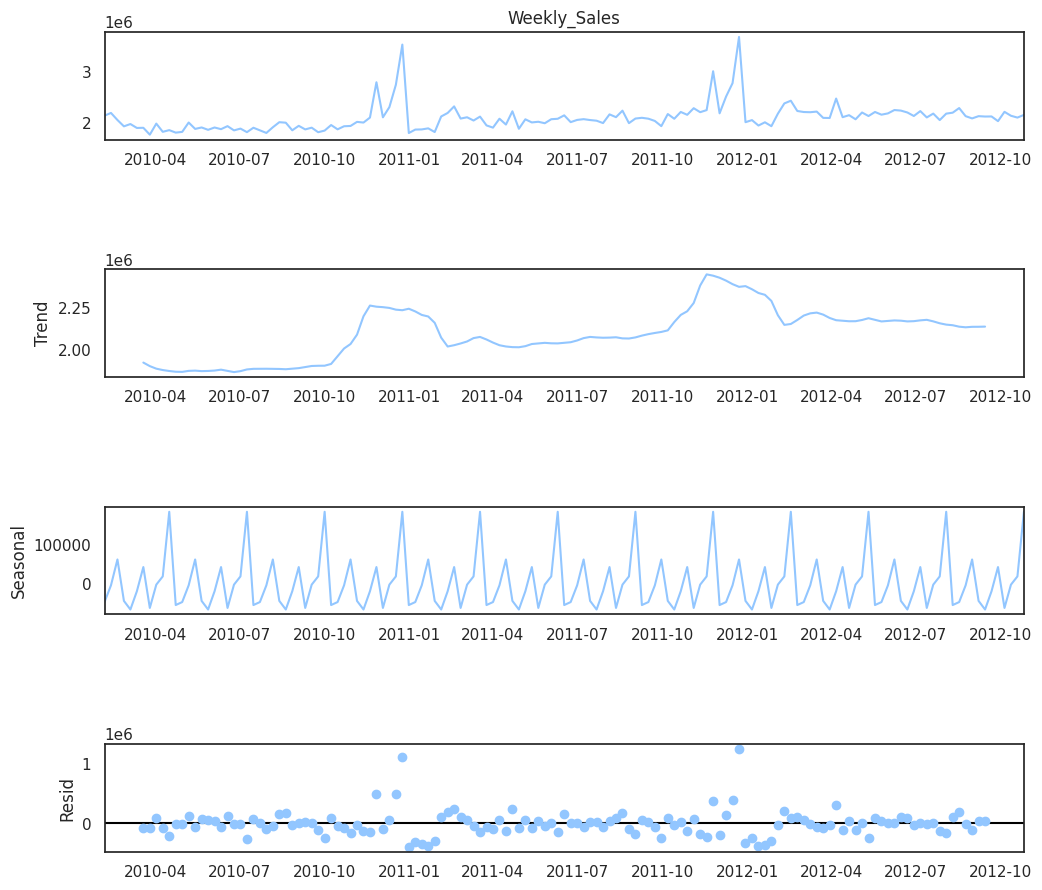

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

Comments: An additive model suggests that the components are added together.
An additive model is linear where changes over time are consistently made by the same amount. We observe it to be a Stationary Time Series as suggested by the Trend and Seasonality graphs. Hence it is an **Additive Time Series** since magnitude of the seasonality component remains relatively constant throughout the time series and the residuals appear to be random and symmetrical around zero.

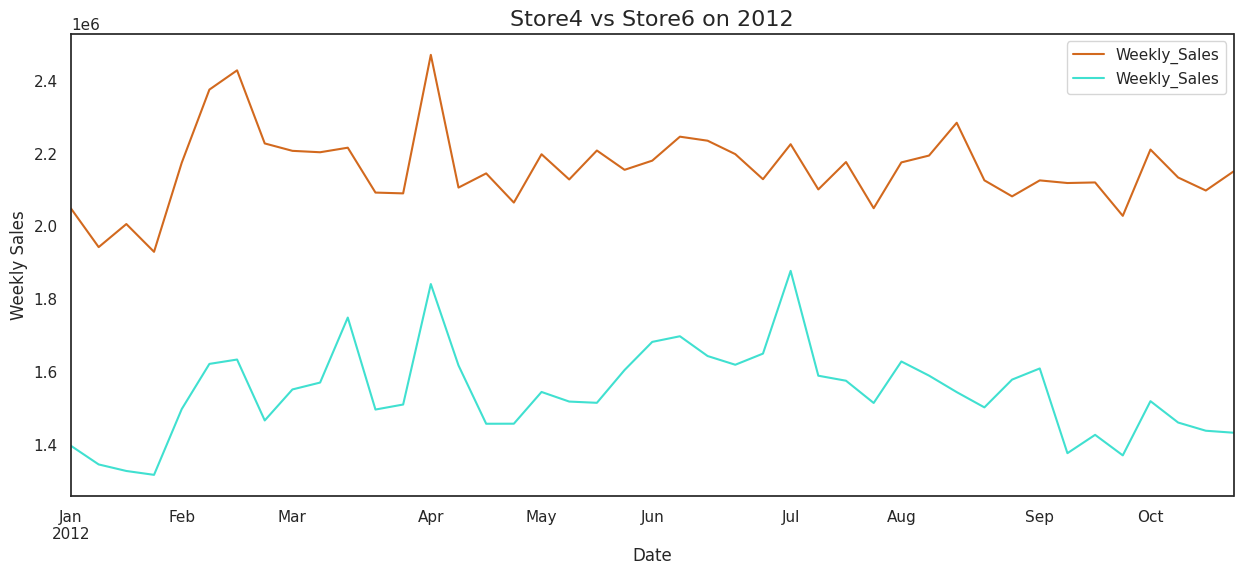

In [127]:
# Lets look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

#5. SARIMA Model

SARIMA uses a combination of autoregression (AR) and moving average (MA) models, as well as differencing, to capture the patterns and seasonality in the data.

In [147]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7624      0.535     -3.295      0.001      -2.811      -0.714
ar.L2         -1.3054      0.578     -2.260      0.024      -2.438      -0.173
ar.L3         -0.6006      0.251     -2.390      0.017      -1.093      -0.108
ar.L4         -0.1900      0.090     -2.104      0.035      -0.367      -0.013
ma.L1         -1.3727      0.486     -2.827      0.005      -2.324      -0.421
ma.L2         -0.2330      1.044     -0.223      0.823      -2.279       1.813
ma.L3          0.6099      0.583      1.045      0.296      -0.534       1.753
ar.S.L52      -0.0682      0.048     -1.418      0.156      -0.163       0.026
sigma2      1.622e+10   5.35e-11   3.03e+20      0.000    1.62e+10    1.62e+10


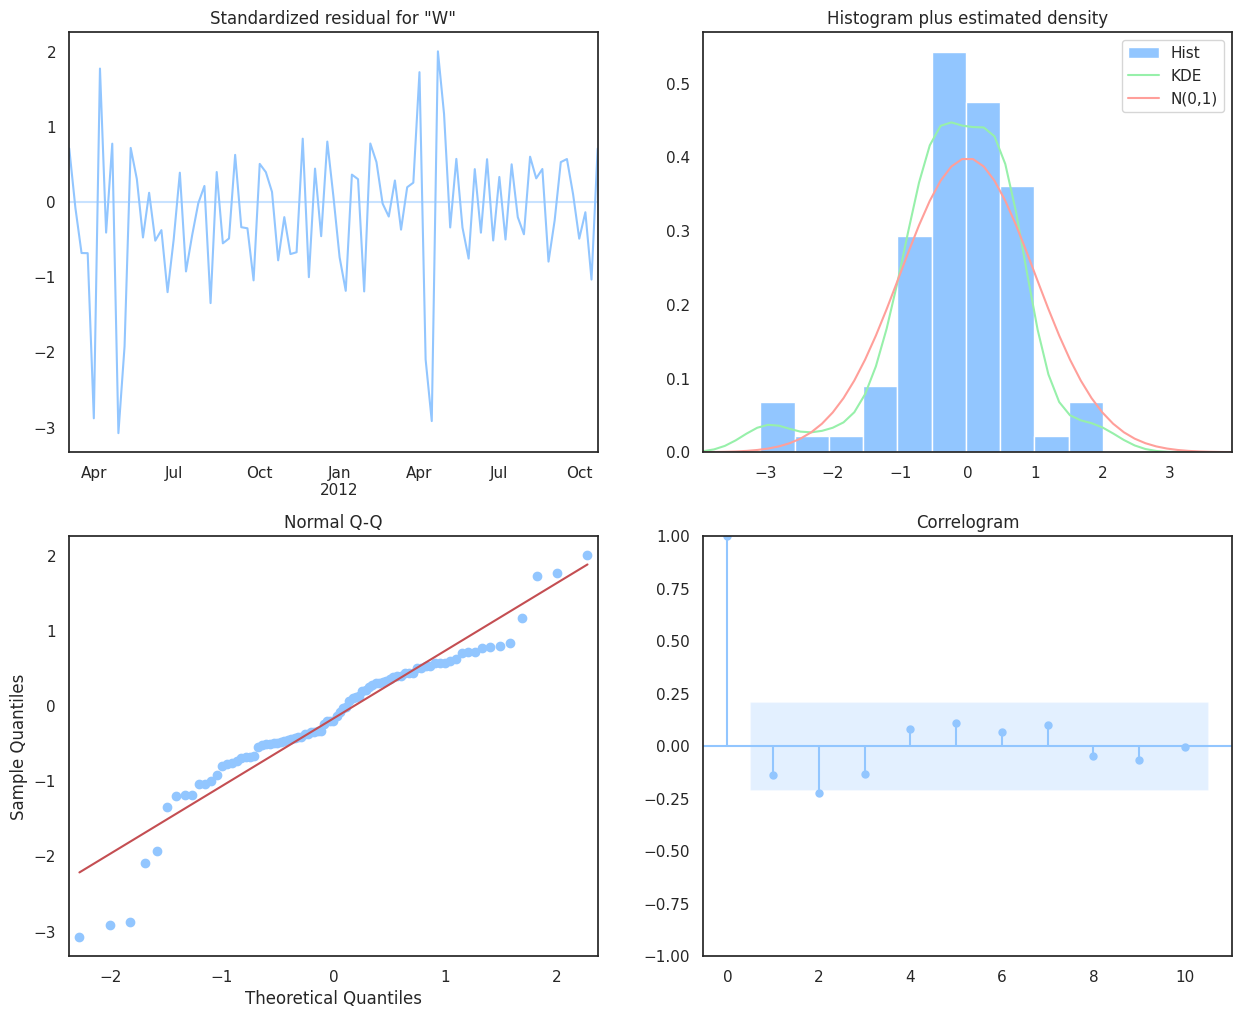

In [148]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

###Prediction for the last 90 days

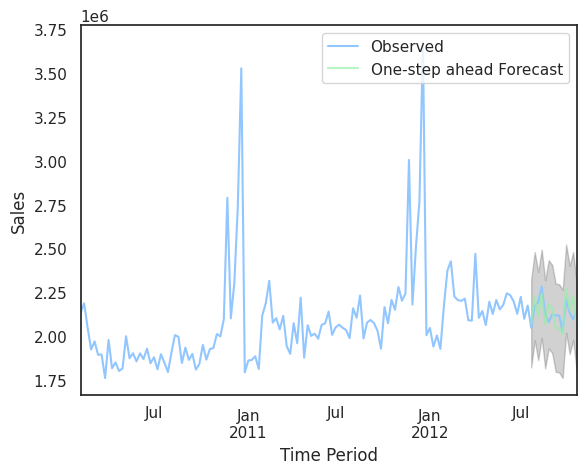

In [149]:
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = y1['2010':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

###Dynamic Forecasting

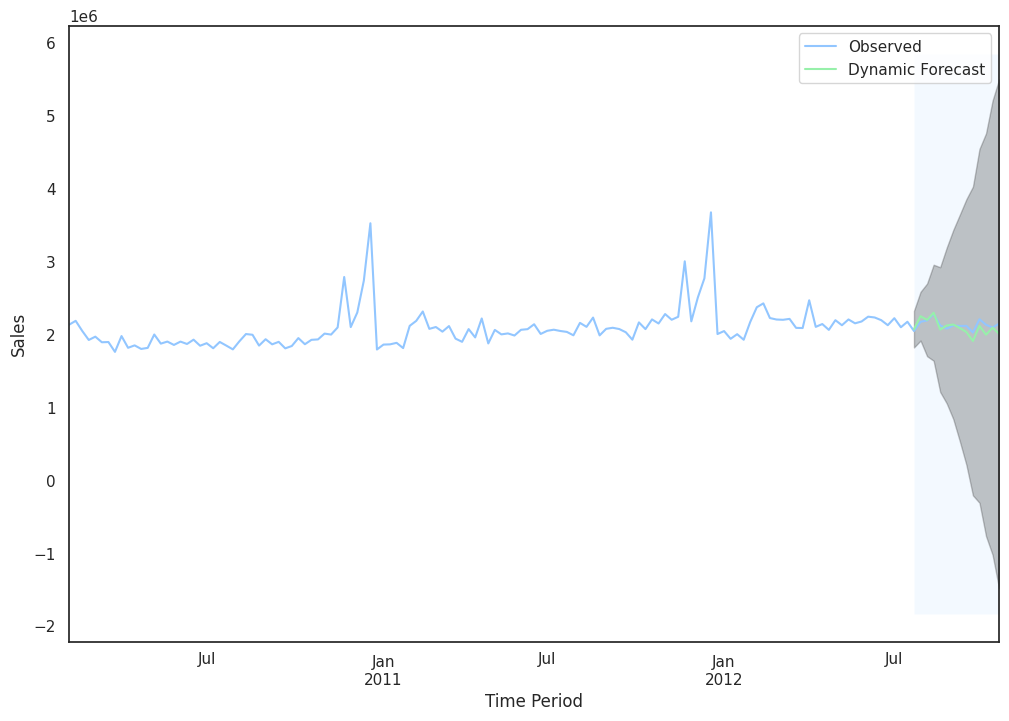

In [150]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ax = y1['2010':].plot(label='Observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

Both the observed and predicted lines go together indicating nearly accurate prediction.


###Sales Forecast for the next 12 weeks

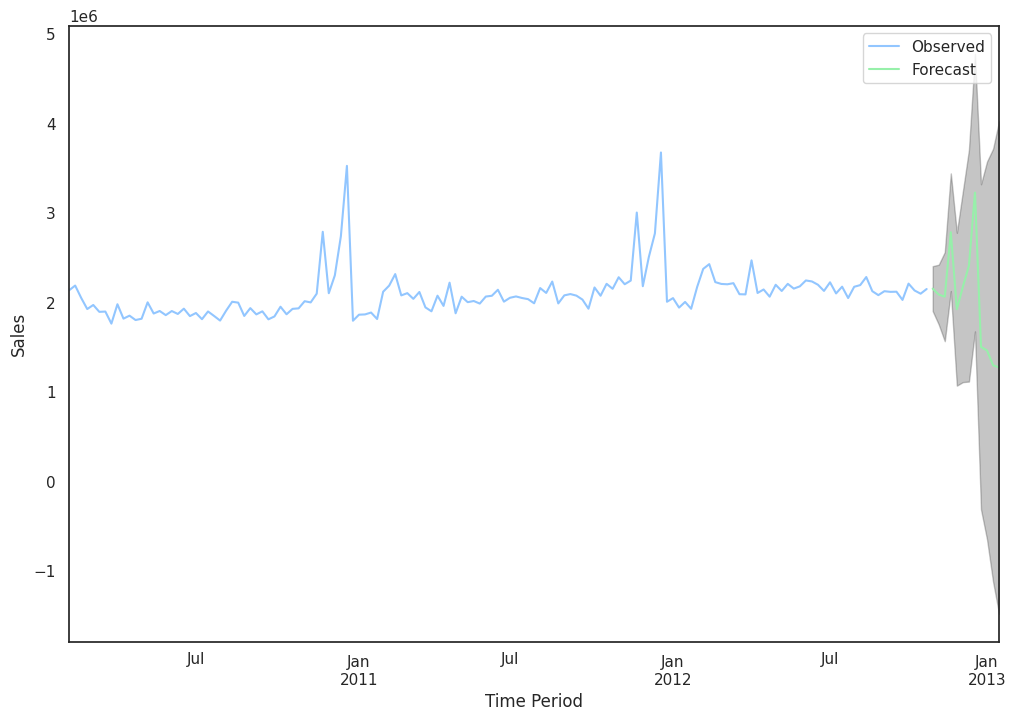

In [151]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = y1.plot(label='Observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()


For future prediction the model is not that great because the error interval is quite big. The green line prediction is almost like earlier years.


### Modeling Data

Train - Test Split


In [152]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 18)
Test: (43, 18)


In [153]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

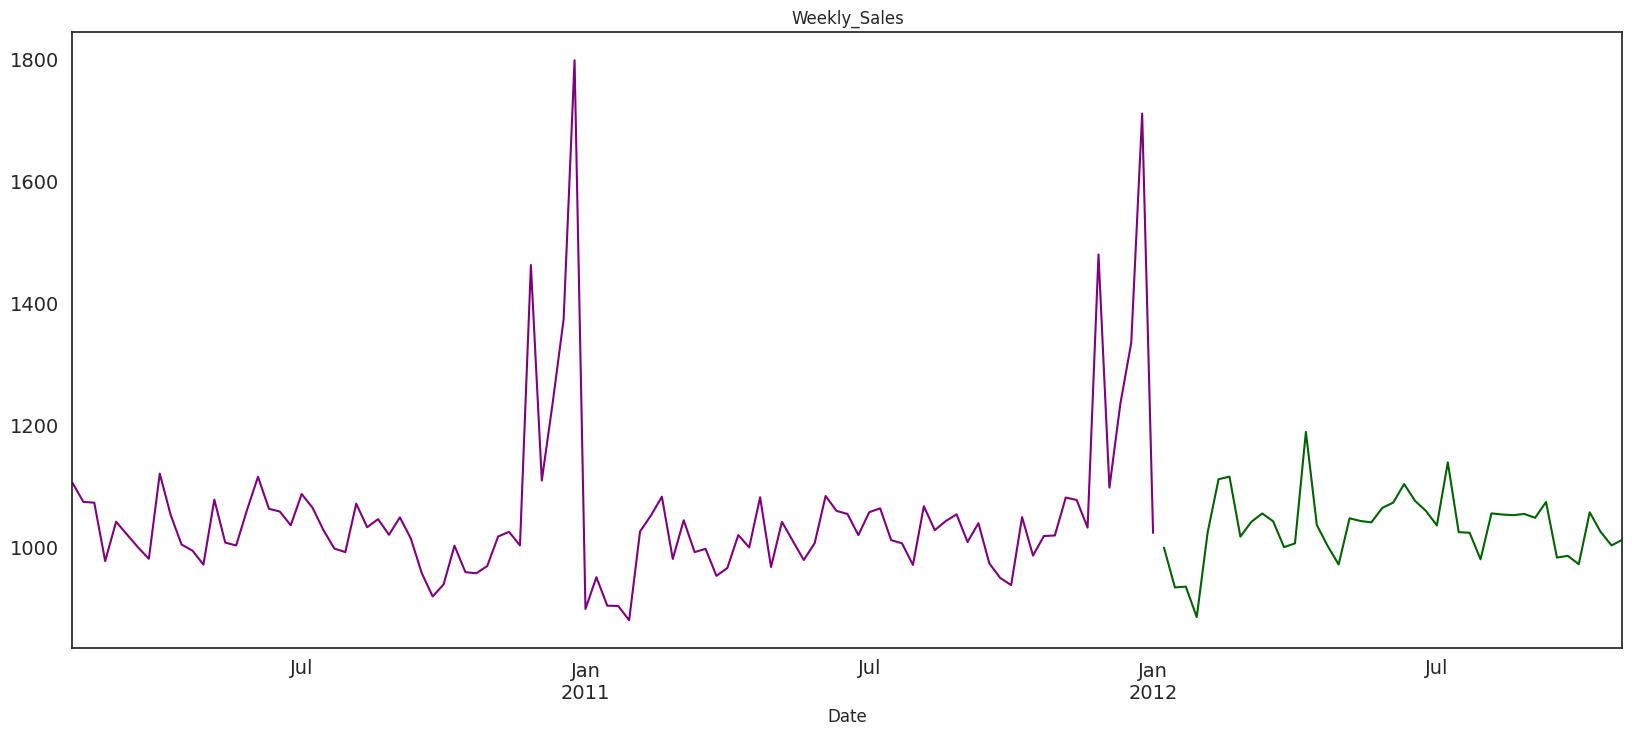

In [154]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14,color='purple')
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14, color='darkgreen')
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. Using this information we can tune our model.


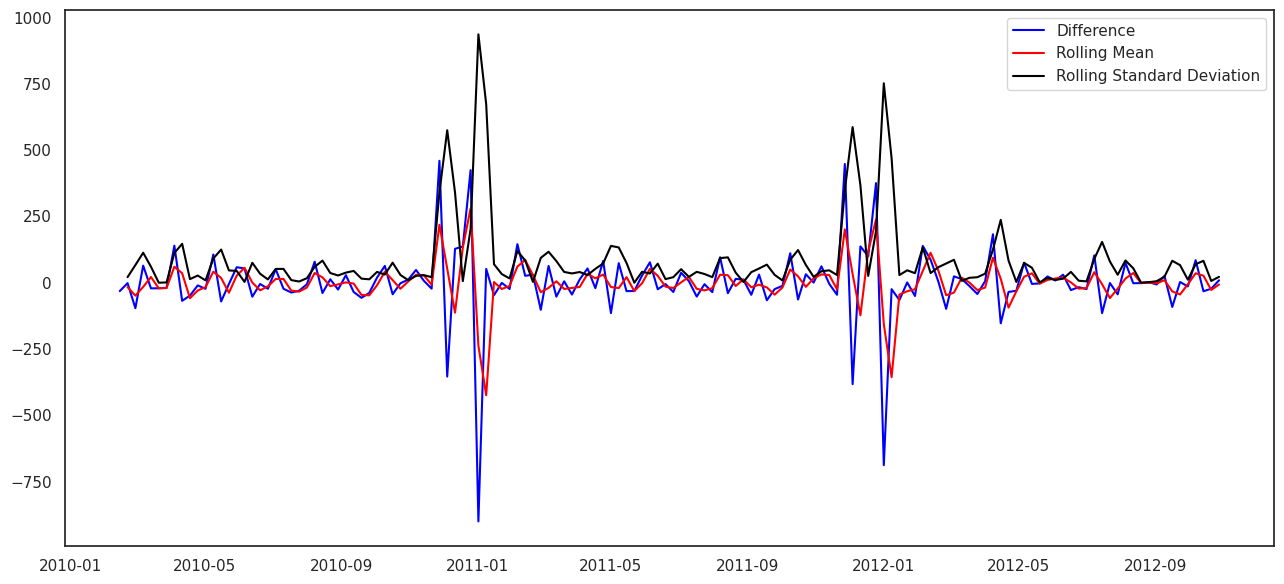

In [155]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

###Weekly Sales Prediction using SARIMA Model

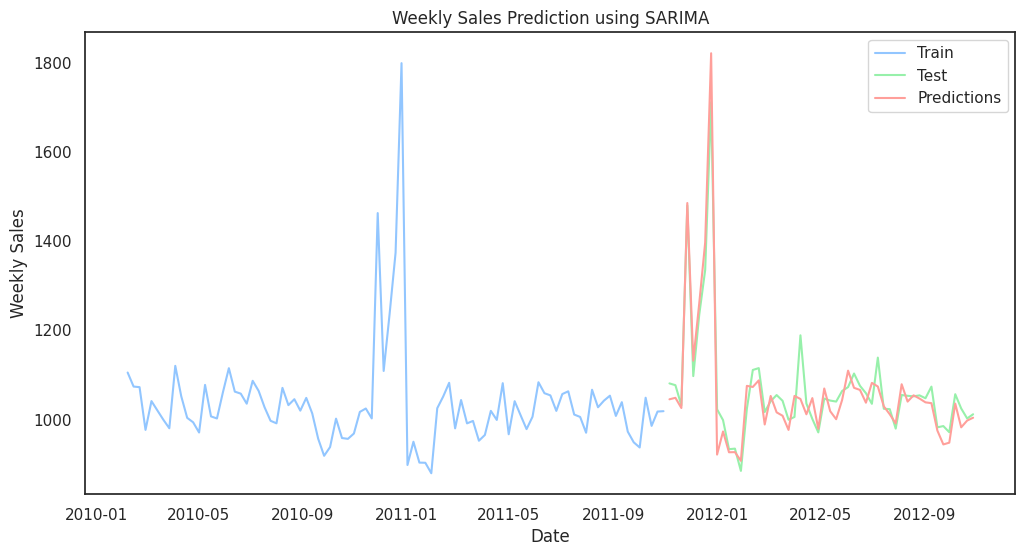

In [156]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming you have a time series dataset with the 'Weekly_Sales' column
# Make sure your dataset is in the correct format with a DateTimeIndex

# Split the data into train and test sets
train_data = df_week['Weekly_Sales'].iloc[:-52]  # Exclude the last 52 weeks for testing
test_data = df_week['Weekly_Sales'].iloc[-52:]  # Last 52 weeks for testing

# Create and fit the SARIMA model
model = sm.tsa.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
model_fit = model.fit()

# Perform prediction for the test period
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Compare the predicted values with the actual test data
predictions = pd.Series(predictions, index=test_data.index)

# Plot the actual values and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Prediction using SARIMA')
plt.legend()
plt.show()


###ACF and PACF Plotting

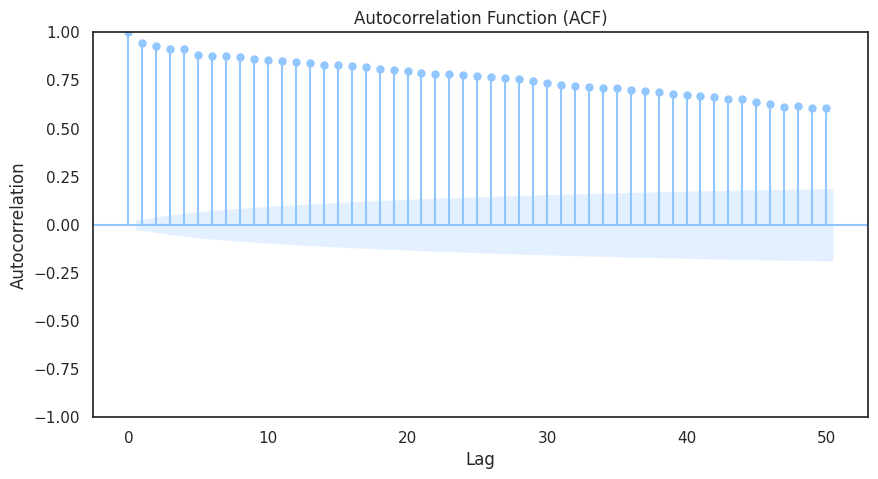

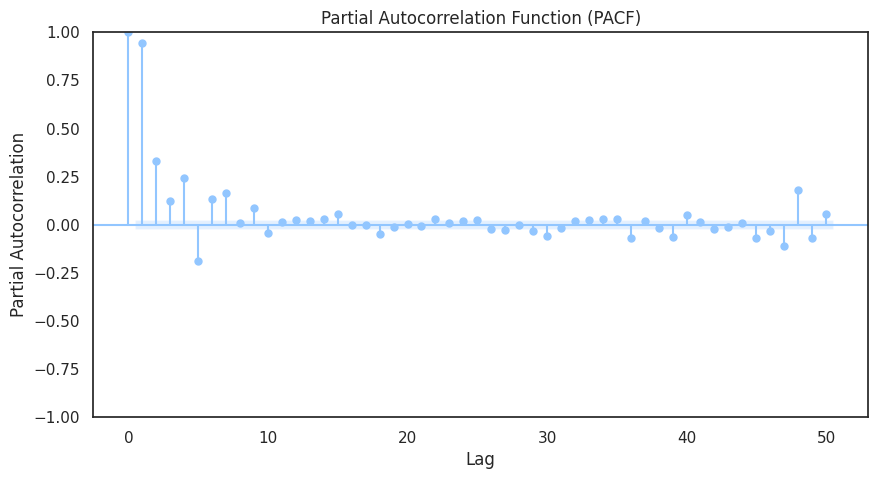

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming your data is stored in a pandas DataFrame called 'data' with a column named 'Weekly_Sales'

# Extract the 'Weekly_Sales' column from the DataFrame
weekly_sales = data['Weekly_Sales']

# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(weekly_sales, lags=50, ax=ax)  # Adjust the 'lags' parameter as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Create the PACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(weekly_sales, lags=50, ax=ax)  # Adjust the 'lags' parameter as needed
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


# 6. Prediction

####Using LSTM (Long Short Term Memory) Model to predict Weekly Sales. LSTM is a type of recurrent neural network (RNN), so we used it here since it is well-suited for capturing patterns and dependencies in sequential data.

Epoch 1/50
161/161 [==============================] - 5s 7ms/step - loss: 0.0086
Epoch 2/50
161/161 [==============================] - 1s 7ms/step - loss: 0.0031
Epoch 3/50
161/161 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 4/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 5/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 6/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0028
Epoch 7/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 8/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 9/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 10/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 11/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 12/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 13/50
161/161 [====

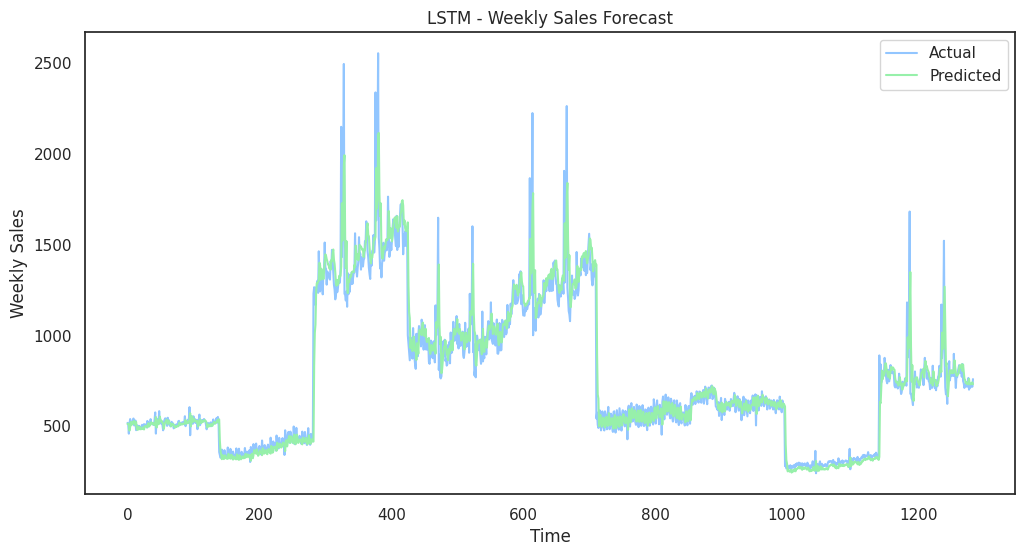

In [161]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Assuming your data is stored in a pandas DataFrame called 'data' with a column named 'Weekly_Sales'

# Extract the 'Weekly_Sales' column from the DataFrame
weekly_sales = data['Weekly_Sales'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weekly_sales)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the training data
X_train, y_train = [], []
lookback = 4  # Number of previous time steps to use as input
for i in range(lookback, len(train_data)):
    X_train.append(train_data[i-lookback:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to match LSTM input shape [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Prepare the test data
X_test, y_test = [], []
for i in range(lookback, len(test_data)):
    X_test.append(test_data[i-lookback:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data to match LSTM input shape [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.title('LSTM - Weekly Sales Forecast')
plt.legend()
plt.show()


LSTM model forecasts future values based on the previous 'lookback' time steps.

### Scatter Plot - Actual vs Predicted

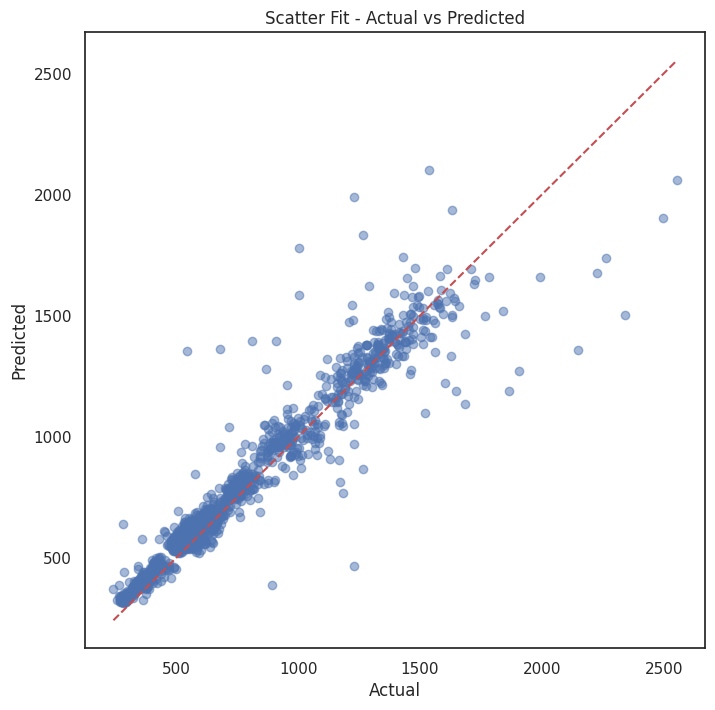

In [160]:
# Plot scatter fit
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, c='b', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Fit - Actual vs Predicted')
plt.show()


##Inferences and Recommendations
1. The largest contributing predictor in the model is the store's size.
2. Each store has a unique prediction power.
3. Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales.
4. Sales peak in November and December and then decline in January. Therefore, it is preferable to hire more casual workers in November and December while encouraging permanent employees to take time off in January.
5. The low selling stores should look forward to increasing their size and capacity to store more items and consumer products.


##Conclusion
When the project is implemented at the departmental level, it helps to plan the inventory and personnel from a central location to each store, which will further aid in better planning and cost-cutting for inventory management, supply chain management, and human resource. The forecasted sales data can be utilised to assess the customer behaviour and modify staffing levels in the store accordingly.